# Dependency Graph Test Strategy Analysis

The following notebook analyzes test results from the experimental `dependency_graph` Azure pipeline. 

Using `script.py`, I've gone ahead and accessed the Azure API to retrieve all logs and parse any relevant details. These results are saved to `azure_runs.csv` and are analyzed in the below cells. 

Some minor details to note:
* The starting date for this experiment is 12/13/2021 and should cover all data up until the current date.
* I've only set up a few stages in the experimental pipeline (no usage stats and isolated to just 3.8). This was to ensure that we didn't use up too many resources and adversely impact developers.
* There haven't been any real deviations - any descrepancies have been manually reviewed and can be `deviations.csv`.
* The `test_cli` stage is conditionally run based on the other stages; as such, it will run less often than the rest of the pipeline.
* The `depth` argument is set at `3`. I think there's a noticable drop in coverage when you go down to `2` and I'm not sure `4` is necessary since we've been able to mirror the results of the primary pipeline.

---

**Conclusion**: I think this test was a success. The sample size is quite small but the fact that the dependency graph test strategy always aligned with our current strategy shows that we can test a subset of our suite without sacrificing accuracy or coverage. 

**Next Steps**:
* Gather a bit more data
* Move this logic to a separate repo/package
* Add tests
* Set up automated full-suite runs and Slack notifications

In [1]:
# 1. Clean data

with open("azure_runs.csv", 'r') as f:
    contents = f.readlines()

test_maps = []
for line in contents:
    parts = line.split(", ")
    success = parts[4]
    tests = parts[6:]
    
    test_map = {}
    for test in tests:
        name, count = test.strip().split(" | ")
        count = int(count)
        test_map[name] = count

    if sum(val for val in test_map.values()) == 0:
        continue

    test_maps.append((success, test_map))

In [2]:
# 2. Define helper function

import statistics
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

def determine_stats_for_pipeline_stage(stage: str, ge_count: int, conditional: bool = False) -> None:
    res = []
    for success, run in test_maps:
        count = run[stage]
        if conditional:
            if success == "succeeded" or count > 0:
                res.append(run[stage])
        else:
            res.append(run[stage])

    mean = statistics.mean(res)
    median = statistics.median(res)
    mode = statistics.mode(res)
    
    print(f"{stage} ({len(res)} runs):")
    print(f"  Mean: 'dependency_graph': {mean:.2f} | 'great_expectations': {ge_count}")
    print(f"  Median: 'dependency_graph': {median:.2f} | 'great_expectations': {ge_count}")
    print(f"  Mode: 'dependency_graph': {mode:.2f} | 'great_expectations': {ge_count}\n")

    plt.hist(res, bins=30, weights=np.ones(len(res)) / len(res))
    plt.ylabel('Percentage')
    plt.xlabel('Test Count');
    plt.axvline(ge_count, color='r', linewidth=3)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

compatibility_matrix Python38-PandasLatest (203 runs):
  Mean: 'dependency_graph': 1466.19 | 'great_expectations': 2721
  Median: 'dependency_graph': 2190.00 | 'great_expectations': 2721
  Mode: 'dependency_graph': 55.00 | 'great_expectations': 2721



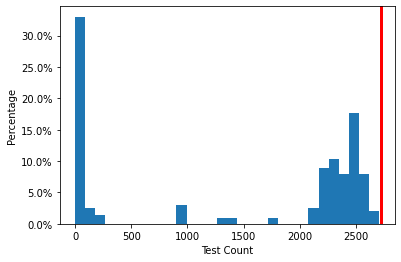

In [3]:
# 3a. Results - compatibility_matrix Python38-PandasLatest

determine_stats_for_pipeline_stage('compatibility_matrix Python38-PandasLatest', 2721)

comprehensive Python38 (203 runs):
  Mean: 'dependency_graph': 3337.80 | 'great_expectations': 5963
  Median: 'dependency_graph': 5291.00 | 'great_expectations': 5963
  Mode: 'dependency_graph': 55.00 | 'great_expectations': 5963



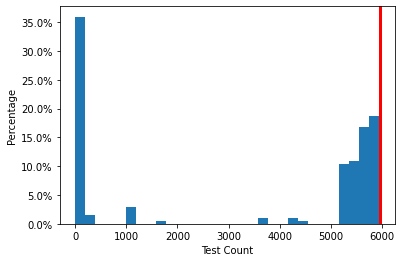

In [4]:
# 3b. Results - comprehensive Python38

determine_stats_for_pipeline_stage('comprehensive Python38', 5963)

mysql (203 runs):
  Mean: 'dependency_graph': 2751.02 | 'great_expectations': 4956
  Median: 'dependency_graph': 4310.00 | 'great_expectations': 4956
  Mode: 'dependency_graph': 55.00 | 'great_expectations': 4956



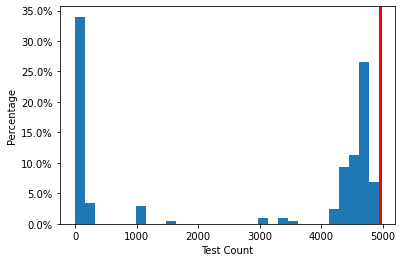

In [5]:
# 3c. Results - mysql (mssql is identical so we only count one to be efficient)

determine_stats_for_pipeline_stage('mysql', 4956)

test_cli (147 runs):
  Mean: 'dependency_graph': 245.03 | 'great_expectations': 451
  Median: 'dependency_graph': 440.00 | 'great_expectations': 451
  Mode: 'dependency_graph': 0.00 | 'great_expectations': 451



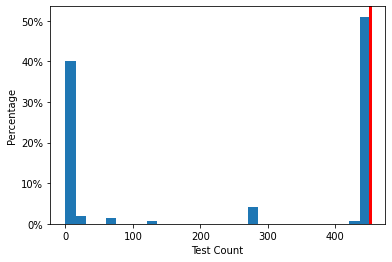

In [6]:
# 3d. Results - test_cli

# We only count instances where this stage is active (hence the reduced number of runs)
determine_stats_for_pipeline_stage('test_cli', 451, conditional=True)

All stages (203 runs):
  Mean: 'dependency_graph': 7732.45 | 'great_expectations': 13966.59
  Median: 'dependency_graph': 12236.00 | 'great_expectations': 14091.00
  Mode: 'dependency_graph': 165.00 | 'great_expectations': 14091.00


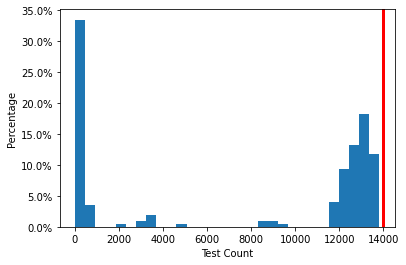

In [7]:
# 3d. Results - All stages

dependency_graph = []
great_expectations = []
for success, run in test_maps:
    dg_count = sum(run.values())
    if dg_count == 0:
        continue
    
    ge_count = 2721 + 5963 + 4956
    if success == "succeeded" or run["test_cli"] > 0:
        ge_count += 451
        
    dependency_graph.append(dg_count)
    great_expectations.append(ge_count)

dg_mean = statistics.mean(dependency_graph)
dg_median = statistics.median(dependency_graph)
dg_mode = statistics.mode(dependency_graph)

ge_mean = statistics.mean(great_expectations)
ge_median = statistics.median(great_expectations)
ge_mode = statistics.mode(great_expectations)

print(f"All stages ({len(dependency_graph)} runs):")
print(f"  Mean: 'dependency_graph': {dg_mean:.2f} | 'great_expectations': {ge_mean:.2f}")
print(f"  Median: 'dependency_graph': {dg_median:.2f} | 'great_expectations': {ge_median:.2f}")
print(f"  Mode: 'dependency_graph': {dg_mode:.2f} | 'great_expectations': {ge_mode:.2f}")

plt.hist(dependency_graph, bins=30, weights=np.ones(len(dependency_graph)) / len(dependency_graph))
plt.ylabel('Percentage')
plt.xlabel('Test Count');
plt.axvline(ge_mean, color='r', linewidth=3)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))